# ⚛️ VQE Ground State Simulation of H₂: Noisy vs. Noiseless Comparison

This notebook runs the **same VQE procedure** for H₂ on:
- A noiseless statevector simulator (`default.qubit`)
- A noisy density-matrix simulator (`default.mixed`) with simple noise channels

It then compares:
- Energy convergence
- Final state populations
- Fidelity of noisy to noiseless ground state


In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt
import os, json, time
from vqe_utils import excitation_ansatz, set_seed, get_optimizer, ensure_dirs
from vqe_utils import RUNS_DIR, RESULTS_DIR, IMG_DIR

# Create folders if needed
ensure_dirs()

# Seeds for repeated runs
seeds = np.arange(0, 5)

# Molecule info
symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.7414]])
basis = "STO-3G"
electrons = 2

# Ansatz and optimizer
ansatz_desc = "UCC singles+doubles"
optimizer_name = "GradientDescent"
stepsize = 0.1
max_iterations = 50

# Build Hamiltonian and Hartree-Fock state
hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates, charge=0, basis=basis)
hf = qchem.hf_state(electrons=electrons, orbitals=qubits)

num_wires = qubits
singles, doubles = qchem.excitations(electrons, qubits)

# Different noise values
noise_levels = [0.0, 0.01, 0.02, 0.04, 0.06, 0.1]


In [4]:
# Define VQE circuits - noisy and noiseless
def get_vqe_qnode(noisy=True, return_state=False,
                  depolarizing_prob=0.0, amplitude_damping_prob=0.0):
    dev_name = "default.mixed" if noisy else "default.qubit"
    dev = qml.device(dev_name, wires=num_wires)

    @qml.qnode(dev, diff_method="finite-diff")
    def circuit(params):
        excitation_ansatz(params, wires=range(num_wires), hf_state=hf,
                          excitations=(singles, doubles), excitation_type="both")
        if noisy:
            for w in range(num_wires):
                qml.DepolarizingChannel(depolarizing_prob, wires=w)
                qml.AmplitudeDamping(amplitude_damping_prob, wires=w)

        return qml.state() if return_state else qml.expval(hamiltonian)

    return circuit


# Run VQE for multiple seeds
def run_vqe(seed, noisy=True, depolarizing_prob=0.0, amplitude_damping_prob=0.0):
    set_seed(seed)
    cost_function = get_vqe_qnode(noisy=noisy, return_state=False,
                                  depolarizing_prob=depolarizing_prob,
                                  amplitude_damping_prob=amplitude_damping_prob)
    opt = get_optimizer(optimizer_name, stepsize=stepsize)
    params = np.zeros(len(singles) + len(doubles), requires_grad=True)
    
    energies = [cost_function(params)]
    for _ in range(max_iterations):
        params, e_prev = opt.step_and_cost(cost_function, params)
        energies.append(e_prev)
    
    final_state = get_vqe_qnode(noisy=noisy, return_state=True,
                                depolarizing_prob=depolarizing_prob,
                                amplitude_damping_prob=amplitude_damping_prob)(params)
    return energies, params, final_state


# Fidelity between pure state and density matrix
def fidelity(pure_ket, rho):
    return np.real(np.conjugate(pure_ket) @ rho @ pure_ket)


# Pure state and energy from noiseless run
noiseless_results = [run_vqe(s, noisy=False) for s in seeds]

# Extract energies and states from the same runs
noiseless_energies = [r[0][-1] for r in noiseless_results]
noiseless_states   = [r[2] for r in noiseless_results]

# Use first state as reference
reference_energy = np.mean(noiseless_energies)
pure_state = noiseless_states[0]


# Compute means and stds of energy errors and fidelities over seeds
def compute_noise_stats(noise_values, dep_prob=0.0, amp_prob=0.0):
    energy_means, energy_stds = [], []
    fidelity_means, fidelity_stds = [], []
    
    for p in noise_values:
        noisy_results = [run_vqe(s, noisy=True, depolarizing_prob=(p if dep_prob else 0.0),
                                 amplitude_damping_prob=(p if amp_prob else 0.0)) for s in seeds]
        
        noisy_energies = [r[0][-1] for r in noisy_results]
        errors = np.array(noisy_energies) - reference_energy
        energy_means.append(np.mean(errors))
        energy_stds.append(np.std(errors))
        
        fidelities = [fidelity(pure_state, r[2]) for r in noisy_results]
        fidelity_means.append(np.mean(fidelities))
        fidelity_stds.append(np.std(fidelities))
    
    return energy_means, energy_stds, fidelity_means, fidelity_stds


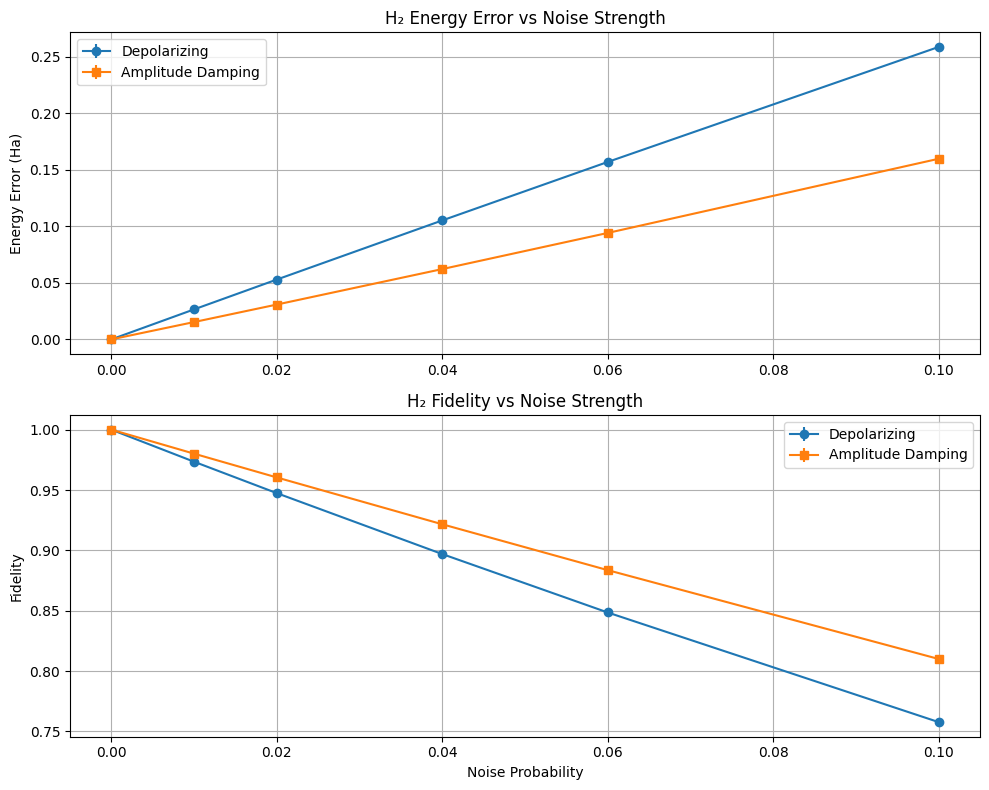

In [5]:
# Depolarizing results
energy_errors_dep, energy_error_stds_dep, fidelity_means_dep, fidelity_stds_dep = compute_noise_stats(
    noise_levels, dep_prob=1, amp_prob=0)

# Amplitude damping results
energy_errors_dep_amp, energy_error_stds_dep_amp, fidelity_means_dep_amp, fidelity_stds_dep_amp = compute_noise_stats(
    noise_levels, dep_prob=0, amp_prob=1)

# Energy subplot
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.errorbar(noise_levels, energy_errors_dep, yerr=energy_error_stds_dep, fmt='o-', label='Depolarizing')
plt.errorbar(noise_levels, energy_errors_dep_amp, yerr=energy_error_stds_dep_amp, fmt='s-', label='Amplitude Damping')
plt.ylabel("Energy Error (Ha)")
plt.title("H₂ Energy Error vs Noise Strength")
plt.legend()
plt.grid(True)

# Fidelity subplot
plt.subplot(2,1,2)
plt.errorbar(noise_levels, fidelity_means_dep, yerr=fidelity_stds_dep, fmt='o-', label='Depolarizing')
plt.errorbar(noise_levels, fidelity_means_dep_amp, yerr=fidelity_stds_dep_amp, fmt='s-', label='Amplitude Damping')
plt.xlabel("Noise Probability")
plt.ylabel("Fidelity")
plt.title("H₂ Fidelity vs Noise Strength")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H2_Noise_error.png", dpi=300)
plt.show()
